## START UP (Run only once and it will restart)

In [ ]:
# Sync auto
from google.colab import drive
!rm -rf /content/sample_data
drive.mount('/gdrive',force_remount=True)
!ln -s "/gdrive/MyDrive/" "/content/Drive"

In [ ]:
!pip install -U pip
!pip install jedi
!pip install -U setuptools wheel
# Pytorch ignite
!pip install -q --pre pytorch-lightning
# Fastai
!pip install -q fastbook
# Albumentations
!pip install -U -q git+https://github.com/albumentations-team/albumentations

## Setup

In [ ]:
import os
import shutil
from glob import glob
from glob import iglob
import random
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
import seaborn as sns
import json
# import autogluon as ag
import warnings
warnings.filterwarnings('ignore')
# from autogluon import ImageClassification as task
from albumentations import *
from fastai.vision.learner import vision_learner
from fastai.vision.models import resnet50
from fastai.metrics import accuracy
from google.colab.patches import cv2_imshow
from fastai.callback.tracker import SaveModelCallback
from fastbook import *
from tqdm.notebook import tqdm

In [ ]:
df_train = pd.read_csv('/content/train.csv').sort_values('label')
df_train

id  label
1961  97b92d80d1a1fdc427ef878d9c566e50.jpg      0
233   ee2c95b340551dc3ee1093537a3a6559.jpg      0
715   3333e8f421546310bc0c71a456bdc234.jpg      0
1965  b67dd0f3634301a08abe5a79f4397be1.jpg      0
2509  253587654c2a99ee57dfd729a7055962.jpg      0
...                                    ...    ...
2347  f663978df805d5b5c670983444aadb6c.jpg     14
2602  e0652f0695980dd65c6dc73929991878.jpg     14
2346  84e84e2cae9e86956d07b2ab20a353d9.jpg     14
1208  dc16789bc7cf2a031ba1746bb70d5b34.jpg     14
1201  bddfab9173a18009ff9477d3b910bfd1.jpg     14

[2725 rows x 2 columns]

## Evaluate Dataset

In [ ]:
train_path = '/content/images/train/'
for i in tqdm(range(len(df_train))):
  filename = str(df_train['id'][i])
  label = str(df_train['label'][i])

  # Create the destination folder if it doesn't exist
  dest_folder = os.path.join(train_path, label)
  if not os.path.exists(dest_folder):
    os.mkdir(dest_folder)

  # Move the file to the new folder
  src_file = os.path.join(train_path, filename)
  dest_file = os.path.join(dest_folder, filename)
  shutil.move(src_file, dest_file)

  0%|          | 0/2725 [00:00<?, ?it/s]

<Axes: xlabel='label', ylabel='id'>

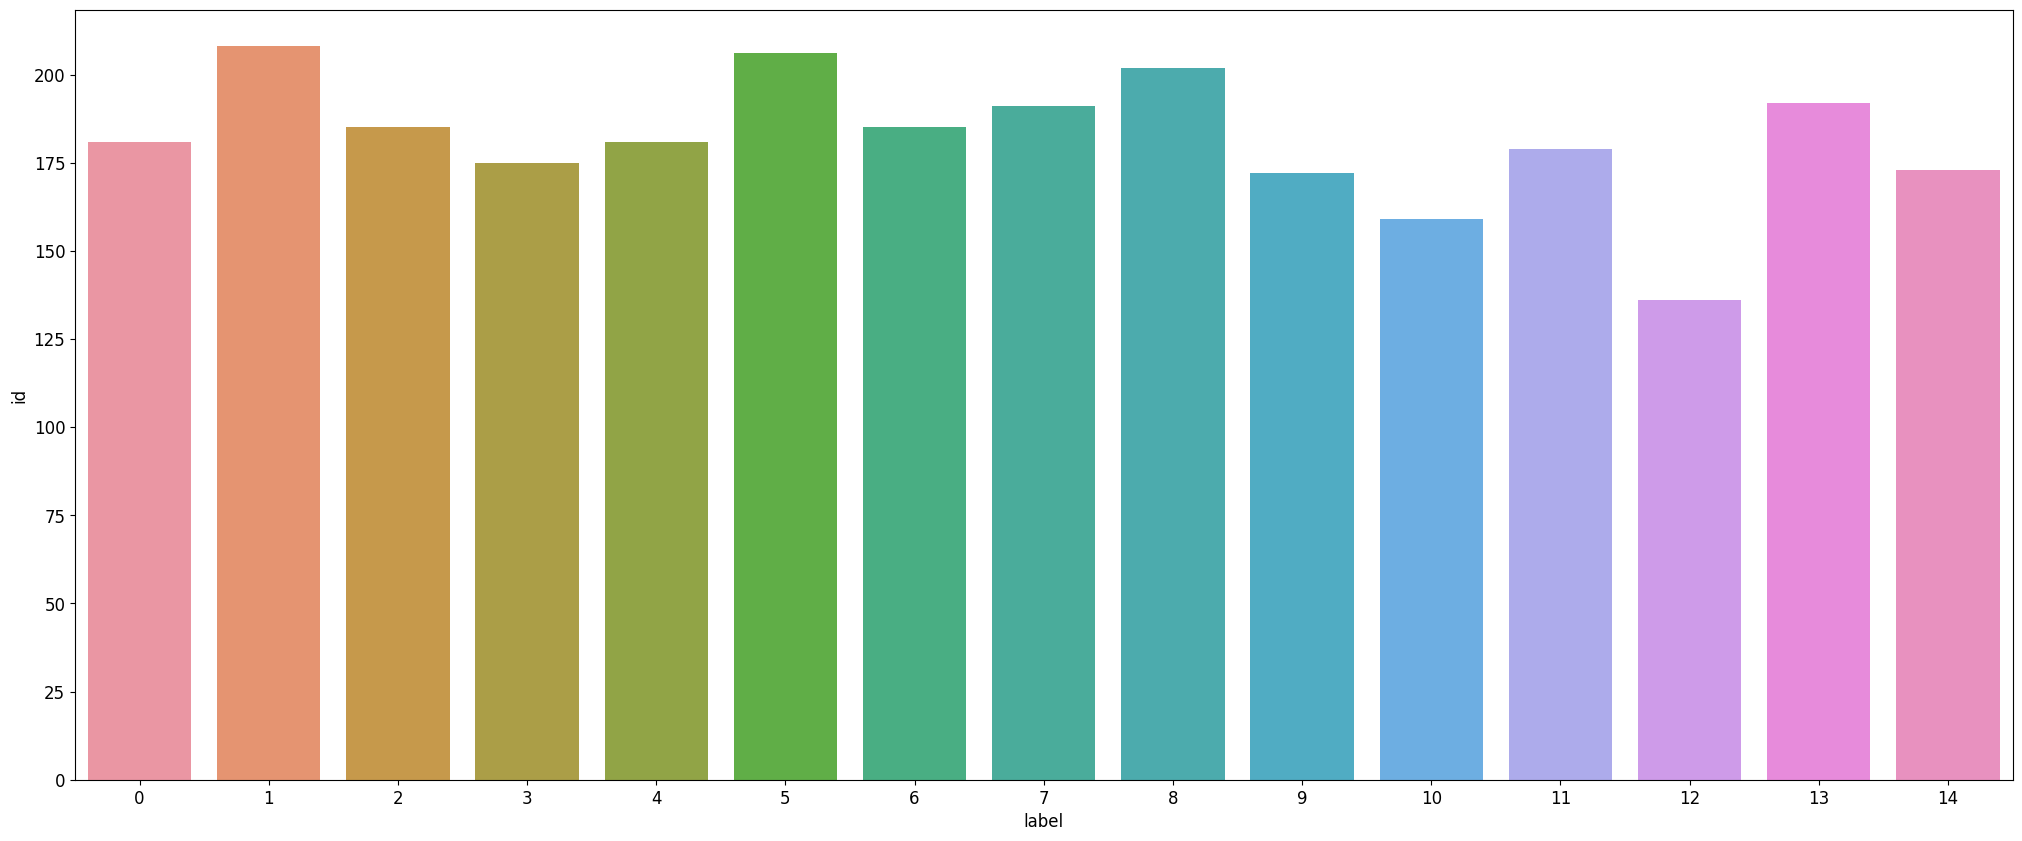

In [ ]:
# Make dataframe
train_count = df_train.groupby('label')['id'].count().reset_index()

# Set figure size
fig, ax = plt.subplots(figsize=(25, 10))

# Make Graph
sns.barplot(data=train_count, x='label', y='id')

## Padding

In [ ]:
# Set the path to the root directory
root_dir = train_path

# Loop through each subdirectory and process the images, sorted by max width
for sub_dir_name in sorted(os.listdir(root_dir), key=lambda x: max([Image.open(os.path.join(root_dir, x, img_file_name)).size[0] for img_file_name in os.listdir(os.path.join(root_dir, x))])):
  sub_dir_path = os.path.join(root_dir, sub_dir_name)
  if os.path.isdir(sub_dir_path):
    sizes = [Image.open(os.path.join(sub_dir_path, img_file_name)).size for img_file_name in os.listdir(sub_dir_path)]
    min_width, min_height = min(sizes)
    max_width, max_height = max(sizes)
    print(f"Directory: {sub_dir_name} | Min Width: {min_width} | Max Width: {max_width} | Min Height: {min_height} | Max Height: {max_height}")

Directory: 14 | Min Width: 300 | Max Width: 3864 | Min Height: 470 | Max Height: 2576
Directory: 9 | Min Width: 163 | Max Width: 4000 | Min Height: 180 | Max Height: 2667
Directory: 5 | Min Width: 192 | Max Width: 4000 | Min Height: 192 | Max Height: 2667
Directory: 4 | Min Width: 300 | Max Width: 4000 | Min Height: 200 | Max Height: 3000
Directory: 12 | Min Width: 200 | Max Width: 4032 | Min Height: 200 | Max Height: 3024
Directory: 11 | Min Width: 192 | Max Width: 4752 | Min Height: 192 | Max Height: 3168
Directory: 8 | Min Width: 250 | Max Width: 4883 | Min Height: 180 | Max Height: 3662
Directory: 3 | Min Width: 218 | Max Width: 4896 | Min Height: 288 | Max Height: 3672
Directory: 2 | Min Width: 359 | Max Width: 4896 | Min Height: 254 | Max Height: 2760
Directory: 7 | Min Width: 249 | Max Width: 4956 | Min Height: 320 | Max Height: 2784
Directory: 6 | Min Width: 194 | Max Width: 5184 | Min Height: 259 | Max Height: 3888
Directory: 0 | Min Width: 183 | Max Width: 5456 | Min Height: 

In [ ]:
# Make padding function to make them all the same size.
def pad_resize_image(image, target_size):
  h, w = image.shape[:2]
  max_area = max(h, w)
  pad_height = (max_area - h) // 2
  pad_width = (max_area - w) // 2
  padded_image = cv2.copyMakeBorder(image, pad_height, pad_height, pad_width, pad_width, cv2.BORDER_CONSTANT)
  # Padding
  resized_image = cv2.resize(padded_image, target_size)
  return resized_image

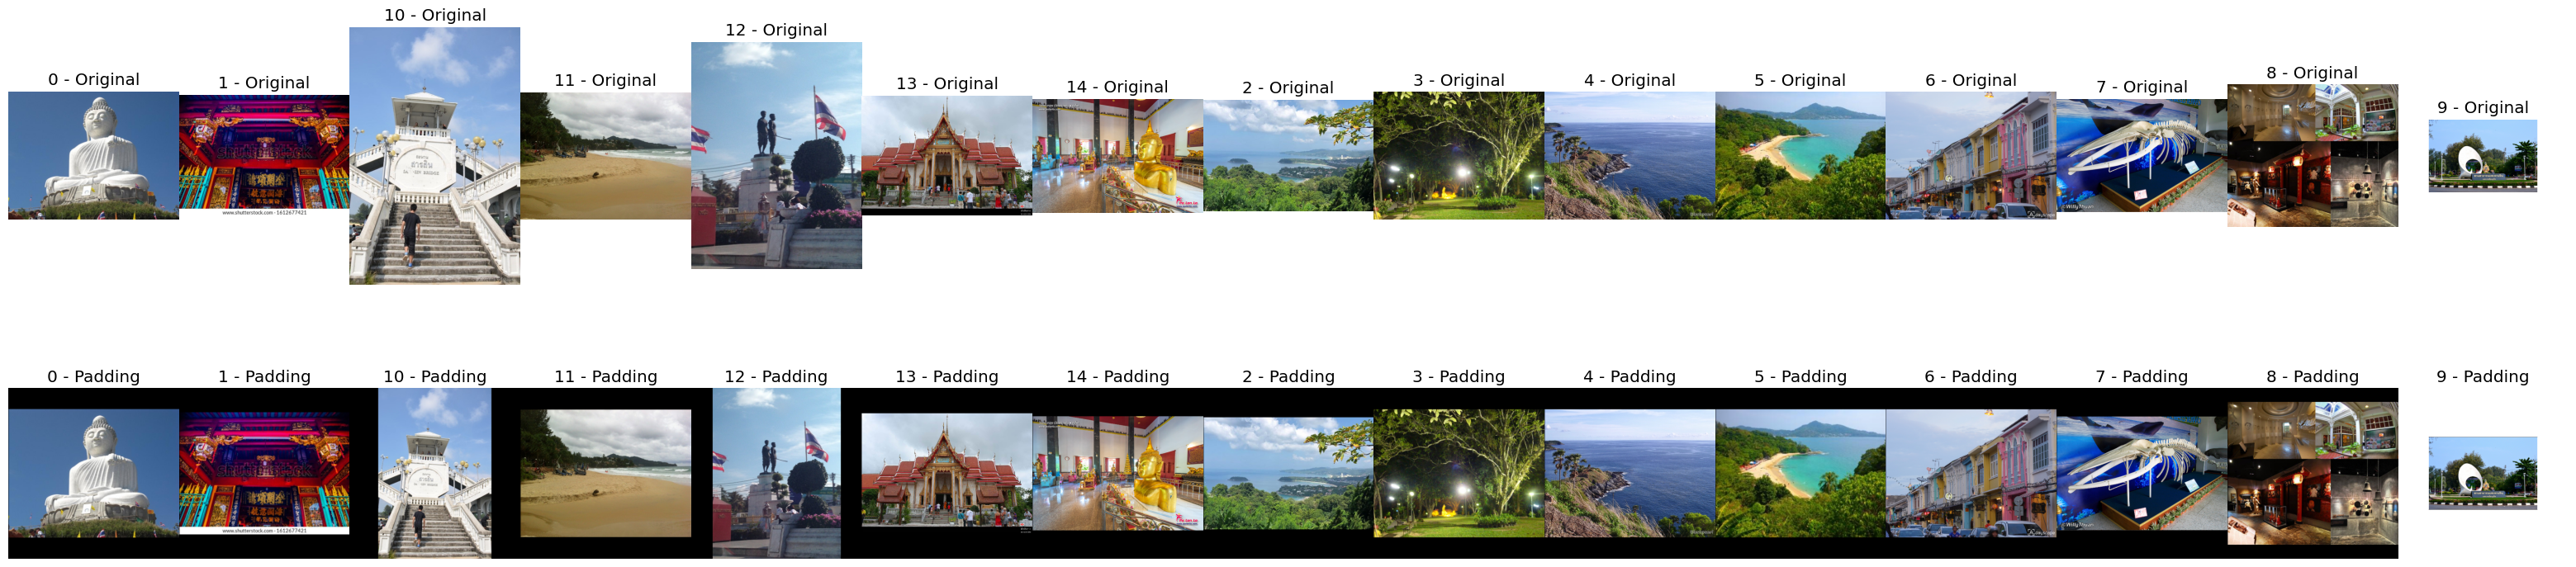

In [ ]:
# Padding all images in the train folder
random.seed(170922)
target_size = (512, 512)

for root, dirs, files in os.walk(train_path):
    if len(dirs) > 0:
        fig, axes = plt.subplots(2, len(dirs), figsize=(40, 10))

        for i, dir in enumerate(sorted(dirs)):
            img_path = os.path.join(root, dir)
            images = os.listdir(img_path)
            random_image = random.choice(images)

            image_path = os.path.join(img_path, random_image)
            image = Image.open(image_path)

            # Plot original image
            axes[0, i].imshow(image)
            axes[0, i].set_title(dir + ' - Original')
            axes[0, i].axis('off')

            # Plot padded image
            image_array = np.array(image)
            padding_image = pad_resize_image(image_array, target_size)
            padding_image[:, 1] = 0 # Change axis of processed image from 1 to 0
            padding_image = Image.fromarray(padding_image)
            axes[1, i].imshow(padding_image)
            axes[1, i].set_title(dir + ' - Padding')
            axes[1, i].axis('off')

        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()

In [ ]:
for root, dirs, files in os.walk(train_path):
  for dir in tqdm(dirs, desc=f"Padding class", leave=False):
    image_path = os.path.join(root, dir)
    for image in os.listdir(image_path):
      image_path_full = os.path.join(image_path, image)
      # Padding
      image = cv2.imread(image_path_full)
      target_size = (512, 512)
      image = pad_resize_image(image, target_size)
      cv2.imwrite(image_path_full, image)

Padding class:   0%|          | 0/15 [00:00<?, ?it/s]

Padding class: 0it [00:00, ?it/s]

Padding class: 0it [00:00, ?it/s]

Padding class: 0it [00:00, ?it/s]

Padding class: 0it [00:00, ?it/s]

Padding class: 0it [00:00, ?it/s]

Padding class: 0it [00:00, ?it/s]

Padding class: 0it [00:00, ?it/s]

Padding class: 0it [00:00, ?it/s]

Padding class: 0it [00:00, ?it/s]

Padding class: 0it [00:00, ?it/s]

Padding class: 0it [00:00, ?it/s]

Padding class: 0it [00:00, ?it/s]

Padding class: 0it [00:00, ?it/s]

Padding class: 0it [00:00, ?it/s]

Padding class: 0it [00:00, ?it/s]

## Split Validation

In [ ]:
split_ratio = 0.10
seed = 170922

train_folder = "/content/images/train"
valid_folder = "/content/images/valid/"

if not os.path.exists(valid_folder):
  os.mkdir(valid_folder)

for class_valid in tqdm((os.listdir(train_folder)), desc="Split Validation"):
  if not os.path.exists(valid_folder + "/" + class_valid): # Make class folder in valid
    os.mkdir(valid_folder + "/" + class_valid)

  files = os.listdir(train_folder + "/" + class_valid)
  random.Random(seed).shuffle(files)
  split_index = int(len(files) * split_ratio)

  for file_name in files[:split_index]:
    img = Image.open(train_folder + "/" + class_valid + "/" + file_name)
    img.save(valid_folder + "/" + class_valid + "/" + file_name)
    os.remove(train_folder + "/" + class_valid + "/" + file_name)

Split Validation:   0%|          | 0/15 [00:00<?, ?it/s]

## Augmentation

In [ ]:
def augment_config(image_array):
    transform = A.Compose([
      A.RandomContrast(limit=0.2, always_apply=True, p=0.5),
      A.CLAHE(p=0.5),
      A.ChannelShuffle(p=0.5),
      A.ColorJitter(p=0.5),
      A.HorizontalFlip(p=0.5),
      # A.ToGray(always_apply=True, p=1.0)
    ])
    augmented = transform(image=image_array)
    return augmented['image']

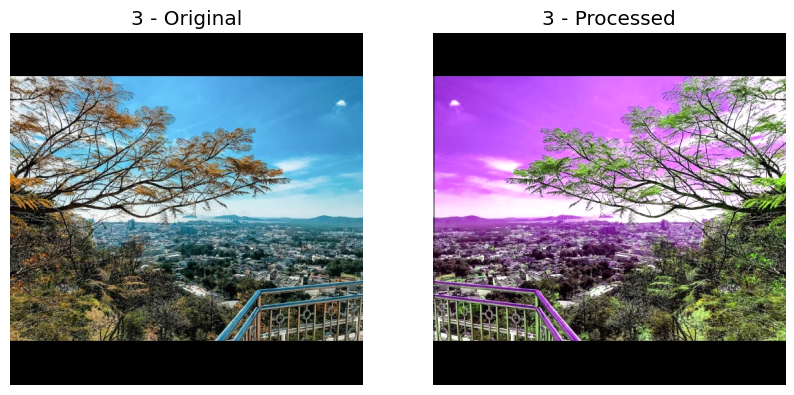

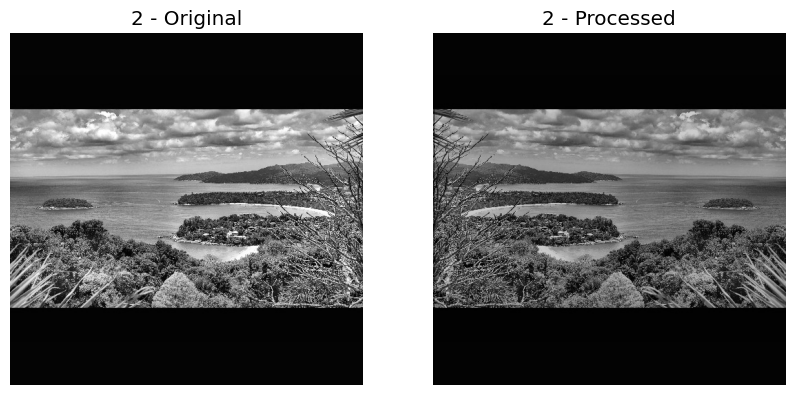

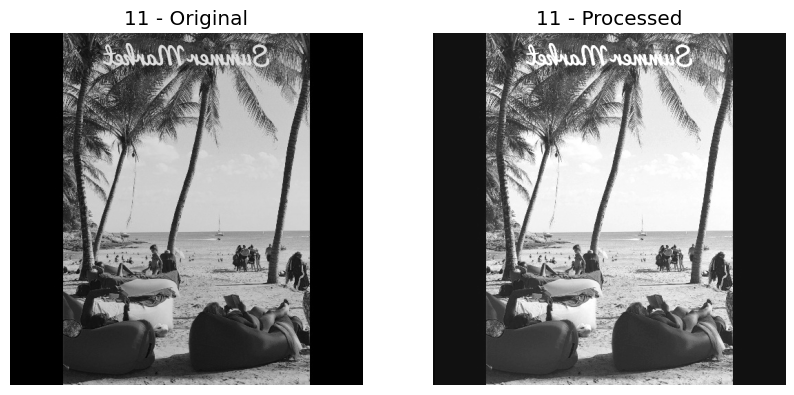

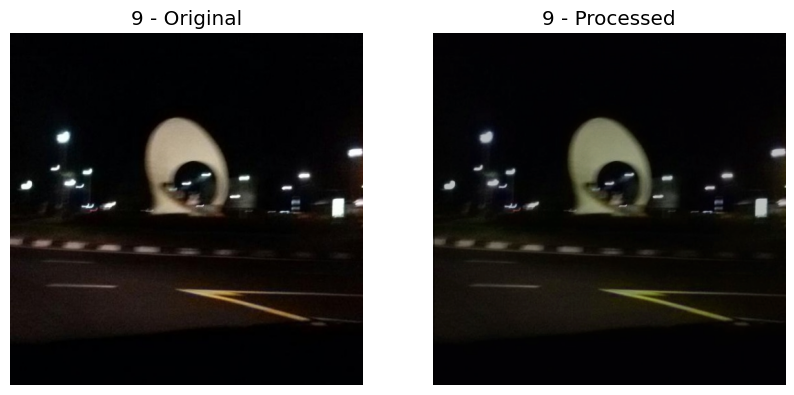

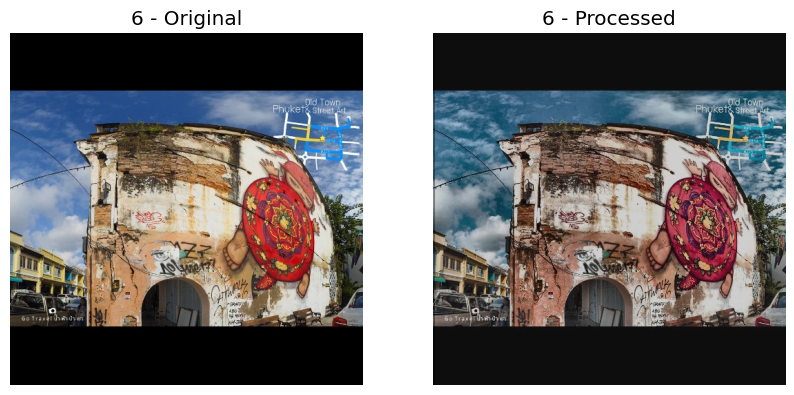

In [ ]:
random.seed(170922)

classes_to_augment = random.sample(os.listdir(train_path), 5)

for dir in classes_to_augment:
  image_path = os.path.join(train_path, dir)
  images = os.listdir(image_path)
  random_image = random.choice(images)

  image_path = os.path.join(image_path, random_image)
  image = Image.open(image_path)

  # Plot image
  image_array = np.array(image)
  process_image = augment_config(image_array)
  process_image[:, 1] = 0 # Change axis of processed image from 1 to 0
  process_image = Image.fromarray(process_image)

  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow(image)
  axes[0].set_title(dir + ' - Original')
  axes[0].axis('off')

  axes[1].imshow(process_image)
  axes[1].set_title(dir + ' - Processed')
  axes[1].axis('off')

  plt.show()

In [ ]:
def augment_images(train_path, max_images_per_class):
    for class_valid in tqdm(os.listdir(train_path), desc='Augmentation'):
        class_path = os.path.join(train_path, class_valid)
        images = os.listdir(class_path)
        num_images = len(images)

        if num_images > max_images_per_class:
            # Randomly remove images until there are only max_images_per_class images in the class
            num_to_remove = num_images - max_images_per_class
            images_to_remove = random.sample(images, num_to_remove)

            for image_name in images_to_remove:
                image_path = os.path.join(class_path, image_name)
                os.remove(image_path)

        elif num_images < max_images_per_class:
            # Randomly augment images until there are max_images_per_class images in the class
            num_to_augment = max_images_per_class - num_images

            for i in range(num_to_augment):
                # Randomly select an image to augment
                image_name = random.choice(images)

                # Check if the image has already been augmented
                if image_name.startswith("augmented_"):
                    continue

                image_path = os.path.join(class_path, image_name)
                image_array = cv2.imread(image_path)
                augmented_image = augment_config(image_array)
                augmented_image_name = f"augmented_{i}_{image_name}"
                augmented_image_path = os.path.join(class_path, augmented_image_name)
                cv2.imwrite(augmented_image_path, augmented_image)

    # Check if each class has max_images_per_class images
    for class_valid in tqdm(os.listdir(train_path), desc='Validation'):
        class_path = os.path.join(train_path, class_valid)
        images = os.listdir(class_path)
        num_images = len(images)

        if num_images != max_images_per_class:
            print(f"Class {class_valid} has {num_images} images after augmentation/removal. Expected {max_images_per_class} images.")

In [ ]:
augment_images(train_path, 270)

Augmentation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

<Axes: xlabel='Class', ylabel='File'>

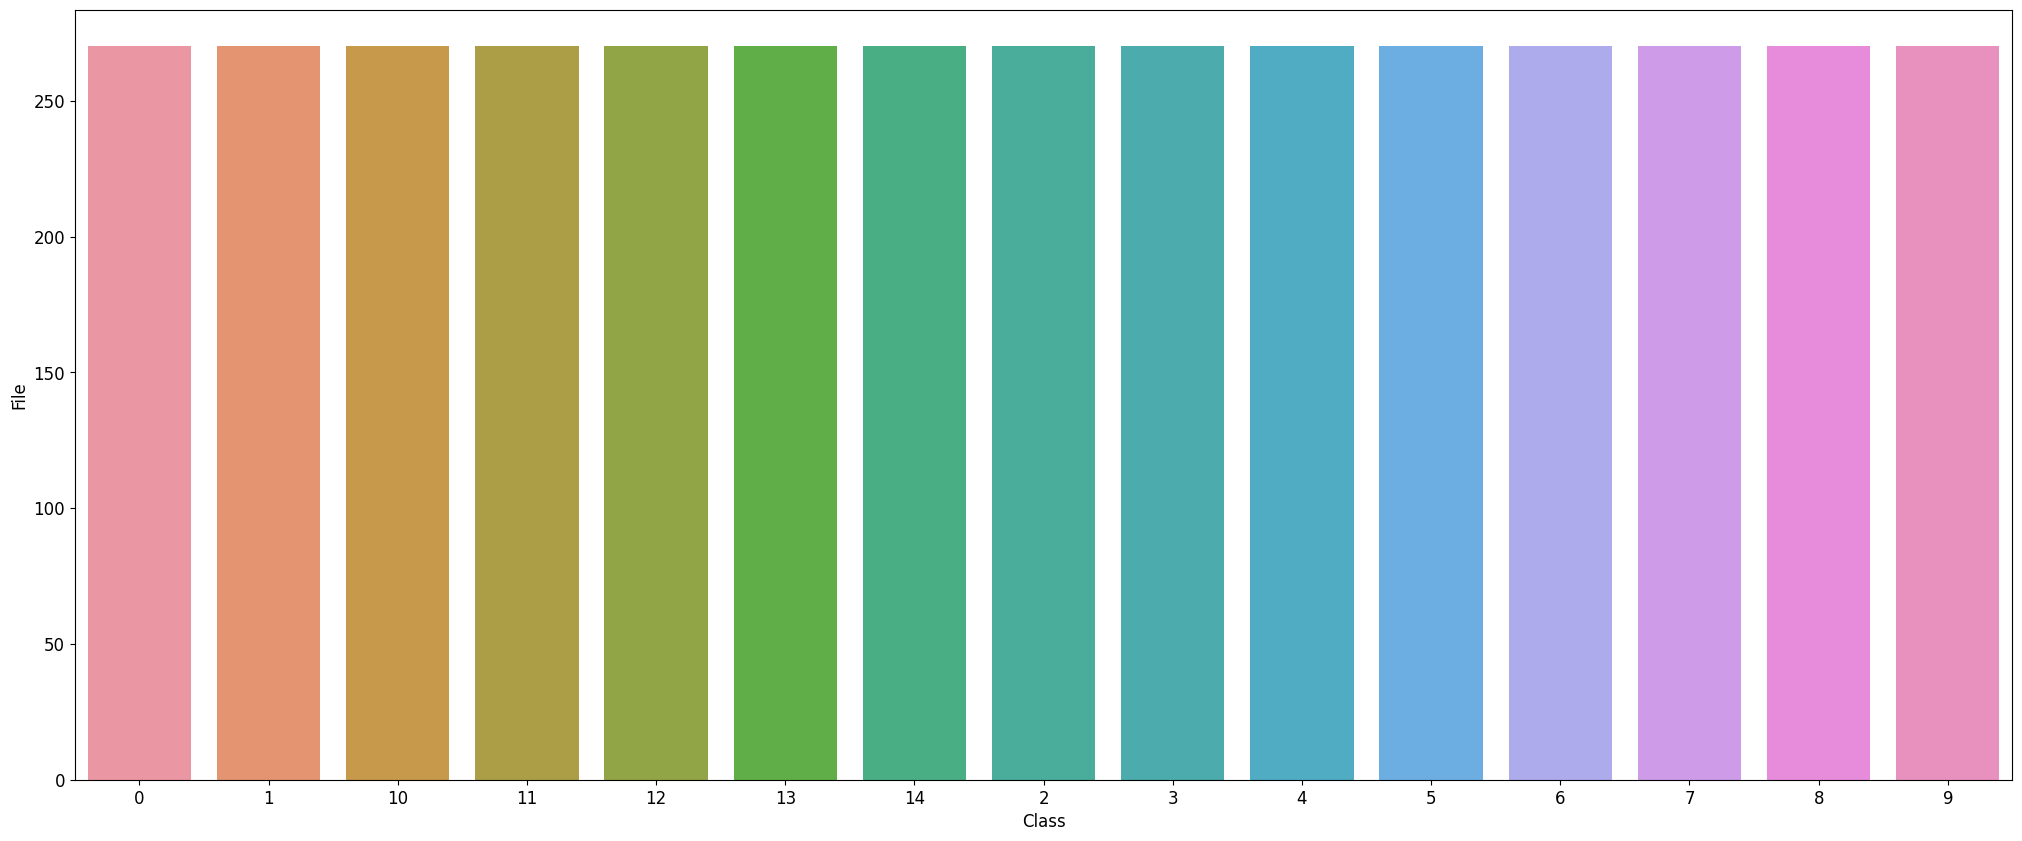

In [ ]:
# Make dataframe
data = []
for root, dirs, files in os.walk(train_path):
  for dir in sorted(dirs):
    subdir_path = os.path.join(root, dir)
    file_count = len(os.listdir(subdir_path))
    data.append({'Class': dir, 'File': file_count})
count_file_aug = pd.DataFrame(data)

# Set figure size
fig, ax = plt.subplots(figsize=(25, 10))

# Make Graph
sns.barplot(data=count_file_aug, x='Class', y='File', ax=ax)

## Train Resnet 50

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #x - image; y - single class
    get_items=get_image_files, #get image
    splitter=GrandparentSplitter(valid_name='valid'), #use parent folder as train-valid split
    get_y=parent_label, #use parent folder as label
    item_tfms=Resize(224)
    )
dls = dblock.dataloaders('/content/images', bs=32)

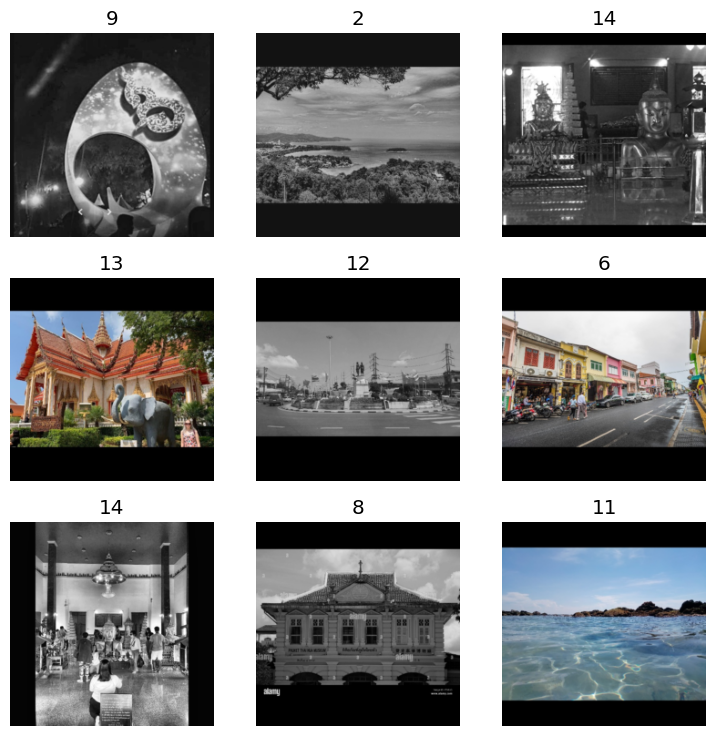

In [ ]:
dls.train.show_batch(max_n=9,nrows=3)

In [ ]:
!mkdir -p /content/MyDrive/Pogus_Rb_Ai/Model/ชื่อmodelของเรา/

In [ ]:
#ตัวอย่างนี้เป็นการใช้ Model resnet 152 มา fine tune หรือสอนมัน
save_dir = '/content/MyDrive/Pogus_Rb_Ai/Model/ชื่อmodelของเรา/'
fname = save_dir + 'Model_Resnet152_Best'
cb = [
    EarlyStoppingCallback(monitor='accuracy', min_delta=0, patience=12),
    SaveModelCallback(monitor='accuracy', fname=fname, every_epoch=False, with_opt=True, reset_on_fit=False)
]
learn = cnn_learner(dls, resnet152, metrics=accuracy, pretrained=True, cbs=cb)
learn.fine_tune(epochs=100, freeze_epochs=1, base_lr=2e-3)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 153MB/s]


Better model found at epoch 0 with accuracy value: 0.7781955003738403.


KeyboardInterrupt: ignored

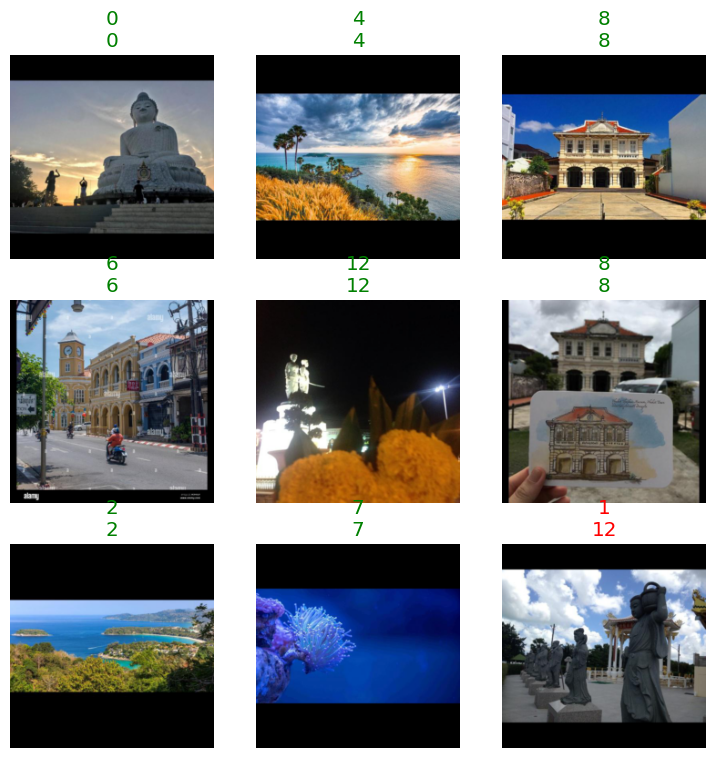

In [ ]:
learn.show_results()

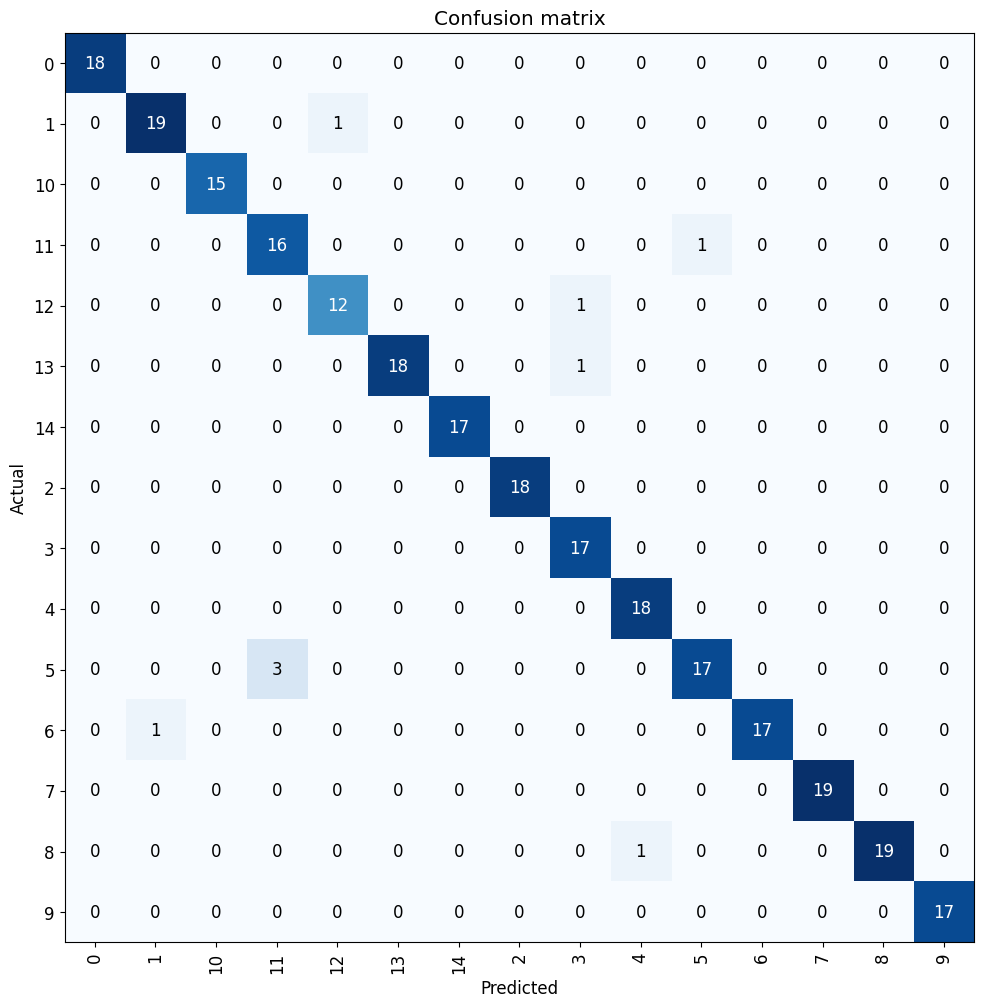

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

##Fast AI load model

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=accuracy, pretrained=True)
learn = learn.load(save_dir + 'Model_Resnet152_Best') # แก้ด้วย

## Test

In [ ]:
df_test = pd.read_csv('/content/test.csv')

In [ ]:
df_test

id
0    6a270f855c45a53c9cd29704e4ec1811.jpg
1    2c76f54dd40ef6747cc2e179c091173c.jpg
2    8a2ab1e2da3aa24c838d2644b8beca77.jpg
3    5b9c7c23ec76a6becf9c9beb4c7bd5f5.jpg
4    6cea6f1ff4873fbcaa4e2ec4e082e361.jpg
..                                    ...
745  5bce0705ef5f0faac903c2faf9c53aca.jpg
746  4c8be14290024ffdce888f29005b060c.jpg
747  3e827c4af3529528da4a1edaccbc8b7a.jpg
748  6f894e140ac980a105dfaa3078389711.jpg
749  5ddfb8bde0b9d39bf56336713e8d2f28.jpg

[750 rows x 1 columns]

In [ ]:
submit = pd.read_csv('/content/submit.csv')

In [ ]:
submit

id  predict
0    6a270f855c45a53c9cd29704e4ec1811.jpg      3.0
1    2c76f54dd40ef6747cc2e179c091173c.jpg      1.0
2    8a2ab1e2da3aa24c838d2644b8beca77.jpg      7.0
3    5b9c7c23ec76a6becf9c9beb4c7bd5f5.jpg      NaN
4    6cea6f1ff4873fbcaa4e2ec4e082e361.jpg      NaN
..                                    ...      ...
745  5bce0705ef5f0faac903c2faf9c53aca.jpg      NaN
746  4c8be14290024ffdce888f29005b060c.jpg      NaN
747  3e827c4af3529528da4a1edaccbc8b7a.jpg      NaN
748  6f894e140ac980a105dfaa3078389711.jpg      NaN
749  5ddfb8bde0b9d39bf56336713e8d2f28.jpg      NaN

[750 rows x 2 columns]

## Predict

In [ ]:
def predict(image):
  test_path = '/content/images/test/' + image
  prediction = learn.predict(test_path)
  pred_class = prediction[0]
  return pred_class

In [ ]:
predict('5bce0705ef5f0faac903c2faf9c53aca.jpg')

'13'

In [ ]:
for image_name in tqdm(submit['id']):
    if pd.isna(submit.loc[submit['id']==image_name, 'predict']).bool():
        predicted_value = predict(image_name)
        submit.loc[submit['id']==image_name, 'predict'] = predicted_value

  0%|          | 0/750 [00:00<?, ?it/s]

In [ ]:
submit

id predict
0    6a270f855c45a53c9cd29704e4ec1811.jpg     3.0
1    2c76f54dd40ef6747cc2e179c091173c.jpg     1.0
2    8a2ab1e2da3aa24c838d2644b8beca77.jpg     7.0
3    5b9c7c23ec76a6becf9c9beb4c7bd5f5.jpg      13
4    6cea6f1ff4873fbcaa4e2ec4e082e361.jpg       3
..                                    ...     ...
745  5bce0705ef5f0faac903c2faf9c53aca.jpg      13
746  4c8be14290024ffdce888f29005b060c.jpg      12
747  3e827c4af3529528da4a1edaccbc8b7a.jpg       9
748  6f894e140ac980a105dfaa3078389711.jpg      12
749  5ddfb8bde0b9d39bf56336713e8d2f28.jpg      11

[750 rows x 2 columns]

In [ ]:
submit.to_csv('/content/MyDrive/predict.csv', index=False) # แก้ชื่อไฟล์